In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Chargement des données

In [2]:
df = pd.read_csv('./CTR.csv', sep= ':', header=None, names=['index', 'representation','annonceur'])

In [3]:
df.head()

,index,representation,annonceur
0,0,0.74837091377052;0.8352077827766918;0.07669895...,0.10341905704918021;0.19069778281037159;0.0;0....
1,1,0.16841851887985582;0.1337544632704264;0.43486...,0.0;0.0;0.0;0.020827097947315257;0.0;0.0;0.022...
2,2,0.4852873193263283;0.5669886866963504;0.041657...,0.10957461446818696;0.13662644655693568;0.0;0....
3,3,0.6222307845696199;0.1961234321879859;0.131146...,0.0;0.1510688622593973;0.0;0.12723939195229092...
4,4,0.3317104123038488;0.08641097481469784;0.02303...,0.0;0.10921436423915529;0.0;0.1519378203628299...


In [4]:
df.shape

(5000, 3)

In [5]:
a = list(map(lambda x : x.split(';'), df['annonceur']))
a = np.array(a).astype(np.float64)

## Baseline

In [6]:
class Agent:
    def __init__(self, nb_bras, dim):
        self.nb_bras = nb_bras
        self.dim = dim
        self.times = np.array([0]* nb_bras)
        self.rewards = np.array([0.0]*nb_bras)
    def choice(self, ctx=None):
        return
    def update(self, action, reward):
        return

### Stratégie Random

In [7]:
class AgentRandom(Agent):
    def __init__(self, nb_bras,dim):
        super().__init__(nb_bras,dim)
    def choice(self, ctx =None):
        return np.random.randint(10)
    def update(self, action, reward):
        idx = np.random.randint(self.nb_bras)
        self.times[idx]+=1
        self.rewards[action] += reward
        return idx

In [8]:
a1 = AgentRandom(10,5)
for i in range(5000):
    idx = a1.choice()
    a1.update(idx, a[i][idx])
print(a1.times)
print(a1.rewards)

[508 502 518 515 470 472 507 477 526 505]
[  8.55843743  40.99322461   4.64267864 134.21114054  15.71351481
   0.78084079  45.33619543  15.58834636   4.23831644 131.23958402]


### Stratégie StaticBest

In [9]:
class  AgentStaticBest(Agent):
    def __init__(self, nb_bras, dim):
        super().__init__(nb_bras,dim)
    def choice(self, ctx =None):
        times = self.times.sum()
        if times<100:
            index = times // 10
            
            return index
        else:
            return np.argmax(self.rewards/self.times)
    def update(self, action, reward):
        #print(reward)
        self.times[action]+=1
        self.rewards[action] += reward
        #print(self.rewards)

In [10]:
a2 = AgentStaticBest(10,5)
for i in range(5000):
    idx = a2.choice()
    a2.update(idx, a[i][idx])
print(a2.times)
print(a2.rewards)

[  10   10   10 4910   10   10   10   10   10   10]
[4.28381994e-01 7.46241035e-01 1.10380968e-01 1.31654383e+03
 1.16234281e-01 0.00000000e+00 1.30824058e+00 4.52357161e-01
 3.89380677e-02 2.38202243e+00]


### Stratégie Optimale

In [11]:
optimal = a.argmax(axis=1)

In [12]:
class Agentoptimal(Agent):
    def __init__(self, nb_bras, dim):
        super().__init__(nb_bras, dim)
    def choice(self, ctx = None):
        return optimal[i]
    def update(self, action, reward):
        self.times[action]+=1
        self.rewards[action] += reward

In [13]:
a3 = Agentoptimal(10,5)
for i in range(5000):
    idx = a3.choice()
    a3.update(idx, a[i][idx])
print(a3.times)
print(a3.rewards)

[   7  146    1 2681   13    0  243    6    0 1903]
[1.27436352e+00 3.15482431e+01 2.05103396e-01 8.72934461e+02
 2.04748753e+00 0.00000000e+00 6.55797526e+01 1.19821485e+00
 0.00000000e+00 5.57215610e+02]


## UCB

In [14]:
class AgentUCB(Agent):
    def __init__(self, nb_bras, dim):
        super().__init__(nb_bras, dim)
        self.idx = 0
        self.max_upper_bound = 0
    def choice(self, ctx = None):
        s = self.times.sum()
        if s<10:
            index = s
            return index
        for k in range(10):
            if self.times[k]>0:
                average_reward = self.rewards[k]/self.times[k]
                delta = np.sqrt(2*np.log10(i)/self.times[k])
                upper_bound = average_reward + delta
            else:
                upper_bound = 1e500
            if upper_bound > self.max_upper_bound:
                self.max_upper_bound = upper_bound
                self.idx = k
        return self.idx
            
    def update(self, action, reward):
        self.times[action]+=1
        self.rewards[action] += reward

In [15]:
a4 = AgentUCB(10,5)

for i in range(5000):
    idx = a4.choice()
    a4.update(idx, a[i][idx])
print(a4.times)
print(a4.rewards)

[   5  215    3 3350    6    3    4  809  133  472]
[1.43129681e-01 1.63207644e+01 0.00000000e+00 8.99155409e+02
 3.27505792e-01 0.00000000e+00 1.94630537e-01 2.72421641e+01
 3.86983769e-01 1.16946581e+02]


## LinUCB

In [16]:
ctx = list(map(lambda x : x.split(';'), df['representation']))
ctx = np.array(ctx).astype(np.float64)

In [17]:
ctx.shape

(5000, 5)

In [18]:
class AgentLinUCB(Agent):
    def __init__(self, nb_bras, dim):
        super().__init__(nb_bras, dim)
        self.alpha = 0.25
        self.Aa = {}
        self.ba = {}
        self.theta = {}
        self.ctx = None
        
    def choice(self, ctx = None):
        p = np.zeros(self.nb_bras)
        self.ctx = ctx
        for k in range(self.nb_bras):
            #print(self.Aa.keys())
            if k not in self.Aa.keys():
                self.Aa[k] = np.identity(self.dim)
                self.ba[k] = np.zeros((self.dim,1))
            self.theta[k] = np.dot(np.linalg.inv(self.Aa[k]), self.ba[k])
            p[k] = self.theta[k].T@ ctx[i] + self.alpha * np.sqrt(ctx[i].T @ np.linalg.inv(self.Aa[k]) @ ctx[i])
        return np.argmax(p)
    def update(self, action, reward):
        self.Aa[action] += np.dot(self.ctx[i],self.ctx[i].T)
        self.ba[action] += reward * self.ctx[i].reshape(5,1)
        self.times[action]+=1
        self.rewards[action] += reward

In [19]:
a5 = AgentLinUCB(10,5)
for i in range(5000):
    idx = a5.choice(ctx)
    a5.update(idx, a[i][idx])
print(a5.times)
print(a5.rewards)

[   8    2    2 2191   52    2  654    5    2 2082]
[1.22581751e-01 0.00000000e+00 0.00000000e+00 6.38115428e+02
 1.95993327e+00 0.00000000e+00 7.92637545e+01 6.97578580e-02
 0.00000000e+00 5.62572528e+02]


In [20]:
barr = []
barr.append(sum(a1.rewards))
barr.append(sum(a2.rewards))
barr.append(sum(a3.rewards))
barr.append(sum(a4.rewards))
barr.append(sum(a5.rewards))

<BarContainer object of 5 artists>

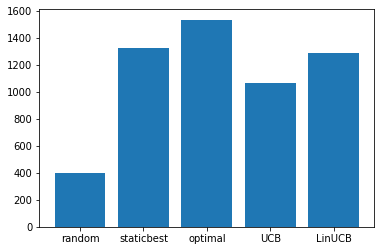

In [21]:
plt.bar(['random','staticbest', 'optimal', 'UCB', 'LinUCB'],barr)